In [42]:
# Get everything setup for dedicated module loading

%load_ext autoreload
%autoreload 2
from renault.plot import *
from renault.get_data import get_pji_with_misssing_fluids_measure, datetime_reshaping
from renault.feature_engineering import feature_engineering
from renault.anomaly_detection import AnomalyDetection


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpy as np 
import pandas as pd
import datetime 

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors, LocalOutlierFactor
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

from sklearn.cluster import KMeans

import plotly.graph_objects as go
import plotly.express as px

# Data Analysis Check

In [4]:
df = pd.read_csv('../data/train_df_LHA.csv',index_col='Unnamed: 0' )
filling = ['ActVolume', 'ActMass']
STEPS = ['StepLoading', 'StepEndLoading']

In [5]:
working_df = datetime_reshaping(df)
working_df

,siteCode,objectUAI,machine,fluid,measurement,step,sourceTimestamp,pji,dataValue,body_type,driving_side,gearbox_type,hybrid_level,engine_type,time,delta
310695,FRLHA,A000003FY5,FillingStation_1,FRFluid,ActLoadingPressure,StepLoading,2021-01-25 11:02:29.625000+00:00,810451,68.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-01-25 11:02:29.625000+00:00,0.000
313513,FRLHA,A000003FY5,FillingStation_1,FRFluid,ActLoadingPressure,StepLoading,2021-01-25 11:02:41.828000+00:00,810451,345.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-01-25 11:02:41.828000+00:00,12.203
305805,FRLHA,A000003FY5,FillingStation_1,FRFluid,ActLoadingPressure,StepLoading,2021-01-25 11:02:46.437000+00:00,810451,474.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-01-25 11:02:46.437000+00:00,4.609
310693,FRLHA,A000003FY5,FillingStation_1,FRFluid,ActLoadingPressure,StepLoading,2021-01-25 11:02:48.937000+00:00,810451,474.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-01-25 11:02:48.937000+00:00,2.500
315053,FRLHA,A000003FY5,FillingStation_1,FRFluid,ActLoadingPressure,StepLoading,2021-01-25 11:02:52.937000+00:00,810451,481.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-01-25 11:02:52.937000+00:00,4.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155787,FRLHA,A000003FY5,FillingStation_1,RMFluid,ActVolume,StepLoading,2021-01-27 20:01:37.640000+00:00,740170,1392.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-01-27 20:01:37.640000+00:00,0.781
162288,FRLHA,A000003FY5,FillingStation_1,RMFluid,ActVolume,StepLoading,2021-01-27 20:01:38.859000+00:00,740170,1393.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-01-27 20:01:38.859000+00:00,1.219
169504,FRLHA,A000003FY5,FillingStation_1,RMFluid,ActVolume,StepLoading,2021-01-27 20:01:40.359000+00:00,740170,1394.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-01-27 20:01:40.359000+00:00,1.500
152151,FRLHA,A000003FY5,FillingStation_1,RMFluid,ActVolume,StepLoading,2021-01-27 20:01:42.531000+00:00,740170,1395.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-01-27 20:01:42.531000+00:00,2.172


Number of steps for each type of measurements

In [9]:
df[df.measurement.isin(filling)].groupby(['fluid','pji', 'step', 'measurement'], as_index=False) \
    .agg({'dataValue': 'describe'}) \
    .groupby(['fluid',  'measurement','step']) \
    .count()

/Users/alix/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/pandas/core/generic.py:4147: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


pji dataValue                             
                                           count mean std min 25% 50% 75% max
fluid   measurement step                                                     
FRFluid ActVolume   StepEndLoading  42        42   42  25  42  42  42  42  42
                    StepLoading     58        58   58  58  58  58  58  58  58
RMFluid ActVolume   StepEndLoading   5         5    5   1   5   5   5   5   5
                    StepLoading     58        58   58  58  58  58  58  58  58

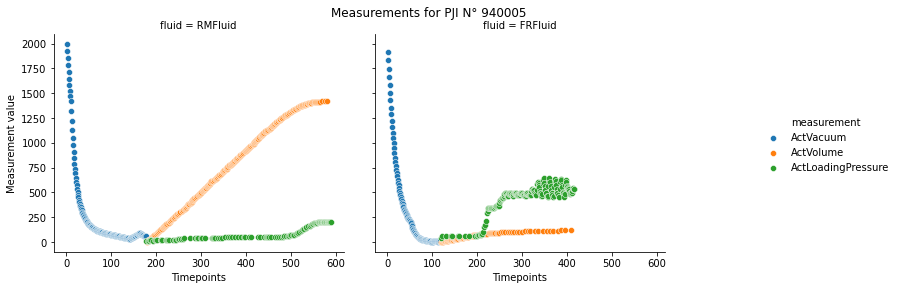

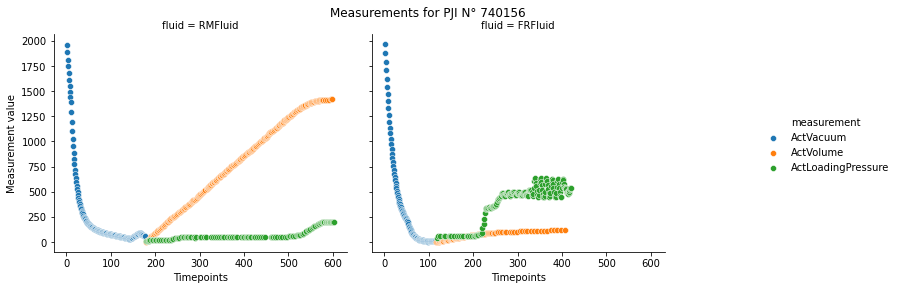

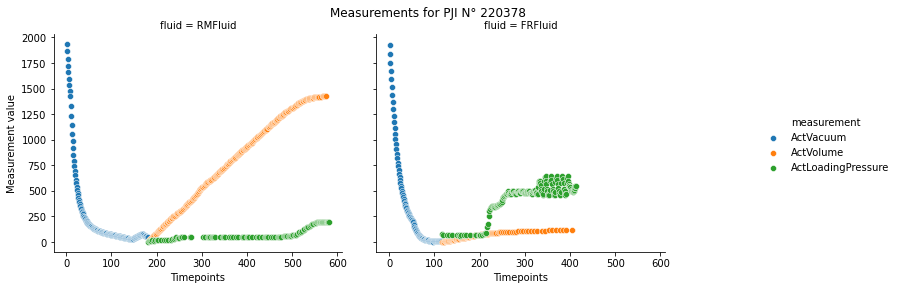

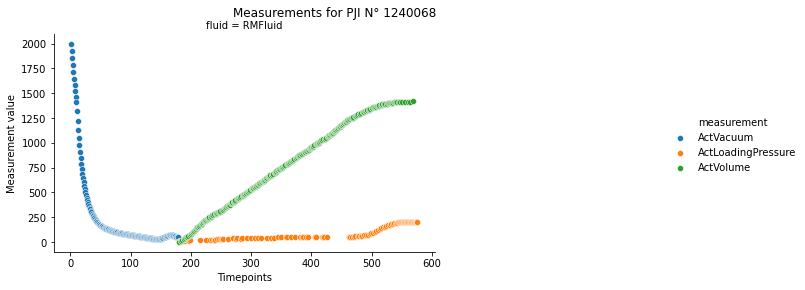

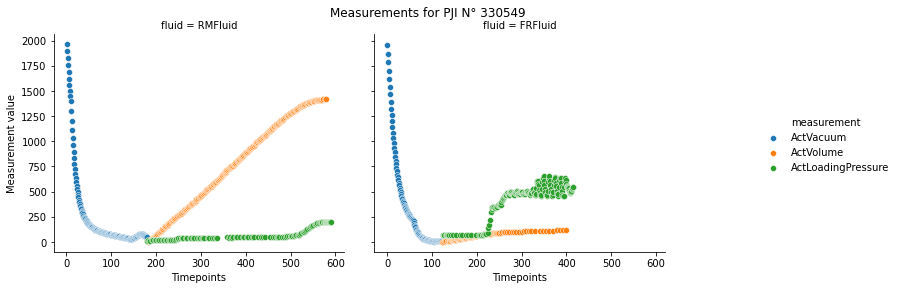

In [10]:
# Plotting some random examples of pji
for num in np.random.choice(df.pji.unique(), 5):
    plot_all_fluid(df,num)

**Analysis of similarit:** Check the global distribution of each fluid and measurement 

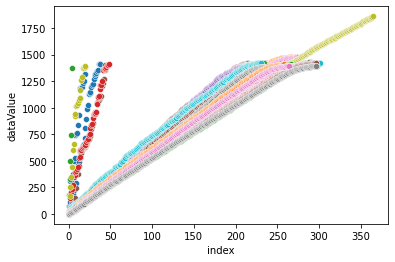

In [11]:

for num in df.pji.unique():
    plot_selective_fluid(df,num, 'RMFluid', 'ActVolume')

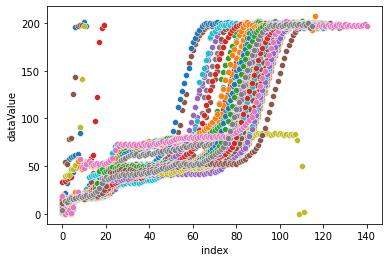

In [13]:
for num in df.pji.unique():
    plot_selective_fluid(df,num, 'RMFluid', 'ActLoadingPressure')

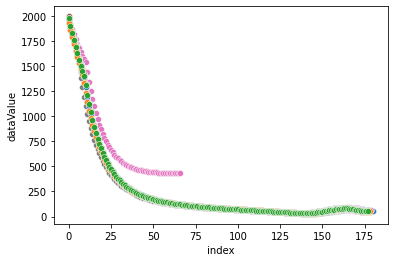

In [115]:
for num in df.pji.unique():
    plot_selective_fluid(df,num, 'RMFluid', 'ActVacuum')

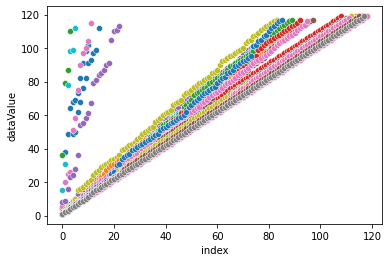

In [12]:
for num in df.pji.unique():
    plot_selective_fluid(df,num, 'FRFluid', 'ActVolume')

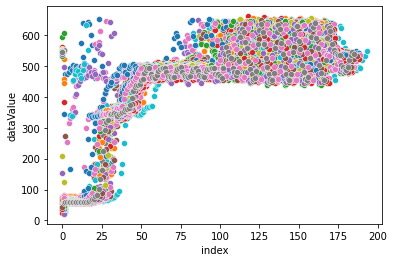

In [14]:
for num in df.pji.unique():
    plot_selective_fluid(df,num, 'FRFluid', 'ActLoadingPressure')

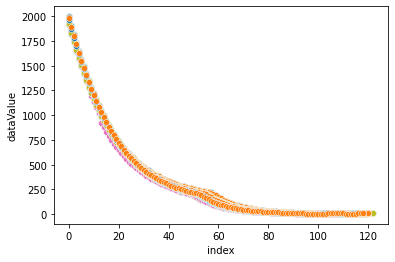

In [114]:
for num in df.pji.unique():
    plot_selective_fluid(df,num, 'FRFluid', 'ActVacuum')

Because only a limited number of PJI have data for the ActVacuum phase, missing cannot be imputed, these phases have to be removed from the anomaly detection

# Preprocessing of training set

In [6]:
# Global organisation of the data
# remove pji without 3 fluids and 3 measurements
filtered_df = working_df[working_df['measurement'] != 'ActVacuum']
train_bad_pji = get_pji_with_misssing_fluids_measure(filtered_df, 2, 2)
filtered_df = filtered_df[~filtered_df.pji.isin(train_bad_pji)]

final_df = feature_engineering(filtered_df)

In [7]:
final_df.head()

,"(dataValue, FRFluid, ActLoadingPressure)","(dataValue, FRFluid, ActVolume)","(dataValue, RMFluid, ActLoadingPressure)","(dataValue, RMFluid, ActVolume)","((delta, count), FRFluid, ActLoadingPressure)","((delta, count), FRFluid, ActVolume)","((delta, count), RMFluid, ActLoadingPressure)","((delta, count), RMFluid, ActVolume)","((delta, mean), FRFluid, ActLoadingPressure)","((delta, mean), FRFluid, ActVolume)",...,"(90%, FRFluid, ActLoadingPressure)","(90%, FRFluid, ActVolume)","(90%, RMFluid, ActLoadingPressure)","(90%, RMFluid, ActVolume)","(max, FRFluid, ActLoadingPressure)","(max, FRFluid, ActVolume)","(max, RMFluid, ActLoadingPressure)","(max, RMFluid, ActVolume)",FRFluid,RMFluid
pji,,,,,,,,,,,,,,,,,,,,,
130567,536.333333,117.0,198.333333,1421.0,179,115,107,296,0.252531,0.377174,...,591.4,106.6,198.0,1370.5,646.0,118.0,200.0,1422.0,1,2
220378,540.333333,118.0,198.000000,1426.0,181,116,110,291,0.250779,0.379991,...,593.0,107.5,198.0,1378.0,650.0,119.0,200.0,1427.0,1,2
310143,517.666667,117.0,197.000000,1389.0,186,115,113,254,0.241349,0.365217,...,577.5,106.6,198.0,1339.6,645.0,118.0,202.0,1390.0,1,2
310167,529.333333,118.0,199.000000,1417.0,185,109,108,291,0.244849,0.409266,...,583.2,108.2,198.0,1369.0,648.0,119.0,200.0,1418.0,1,2
310586,537.333333,117.0,198.000000,1420.0,194,115,120,299,0.233005,0.383296,...,589.7,106.6,198.0,1367.6,647.0,118.0,200.0,1421.0,1,2


# Preprocessing of test dataset

In [48]:
test = pd.read_csv('../data/inference_df_LHA.csv', index_col='Unnamed: 0')

test = test.dropna() # Last line contains only na but that's the only one
test.head()

,siteCode,objectUAI,machine,fluid,measurement,step,sourceTimestamp,pji,dataValue,body_type,driving_side,gearbox_type,hybrid_level,engine_type
2,FRLHA,A000003FY5,FillingStation_1,RMFluid,ActVolume,StepLoading,2021-01-28 10:50:38.687000+00:00,4730232.0,823.0,F82,DG,BVM6,NOT_HYBRID,M9R
3,FRLHA,A000003FY5,FillingStation_1,FRFluid,ActLoadingPressure,StepLoading,2021-01-28 10:50:51.906000+00:00,4730232.0,610.0,F82,DG,BVM6,NOT_HYBRID,M9R
5,FRLHA,A000003FY5,FillingStation_1,FRFluid,ActVolume,StepLoading,2021-01-28 11:04:23.796000+00:00,5230145.0,31.0,F82,DG,BVM6,NOT_HYBRID,M9R
11,FRLHA,A000003FY5,FillingStation_1,RMFluid,ActVolume,StepLoading,2021-01-28 11:04:29.703000+00:00,5230145.0,309.0,F82,DG,BVM6,NOT_HYBRID,M9R
24,FRLHA,A000003FY5,FillingStation_1,RMFluid,ActVolume,StepLoading,2021-01-28 10:50:40.796000+00:00,4730232.0,920.0,F82,DG,BVM6,NOT_HYBRID,M9R


In [49]:
test_reshaped = datetime_reshaping(test)
test_reshaped.head()

,siteCode,objectUAI,machine,fluid,measurement,step,sourceTimestamp,pji,dataValue,body_type,driving_side,gearbox_type,hybrid_level,engine_type,time,delta
8336,FRLHA,A000003FY5,FillingStation_1,FRFluid,ActLoadingPressure,StepLoading,2021-01-28 10:50:18.296000+00:00,4730232.0,540.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-01-28 10:50:18.296000+00:00,0.000
3557,FRLHA,A000003FY5,FillingStation_1,FRFluid,ActLoadingPressure,StepLoading,2021-01-28 10:50:18.687000+00:00,4730232.0,42.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-01-28 10:50:18.687000+00:00,0.391
4446,FRLHA,A000003FY5,FillingStation_1,FRFluid,ActLoadingPressure,StepLoading,2021-01-28 10:50:18.906000+00:00,4730232.0,60.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-01-28 10:50:18.906000+00:00,0.219
3877,FRLHA,A000003FY5,FillingStation_1,FRFluid,ActLoadingPressure,StepLoading,2021-01-28 10:50:19.093000+00:00,4730232.0,61.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-01-28 10:50:19.093000+00:00,0.187
2199,FRLHA,A000003FY5,FillingStation_1,FRFluid,ActLoadingPressure,StepLoading,2021-01-28 10:50:19.406000+00:00,4730232.0,62.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-01-28 10:50:19.406000+00:00,0.313


In [10]:
# remove pji without 2 fluids and 2 measurements
test_reshaped = test_reshaped[test_reshaped['measurement'] != 'ActVacuum']
bad_pji = get_pji_with_misssing_fluids_measure(test_reshaped, 2, 2)

test_reshaped = test_reshaped[~test_reshaped.pji.isin(bad_pji)]


test_final_df = feature_engineering(test_reshaped)
test_final_df

,"(dataValue, FRFluid, ActLoadingPressure)","(dataValue, FRFluid, ActVolume)","(dataValue, RMFluid, ActLoadingPressure)","(dataValue, RMFluid, ActVolume)","((delta, count), FRFluid, ActLoadingPressure)","((delta, count), FRFluid, ActVolume)","((delta, count), RMFluid, ActLoadingPressure)","((delta, count), RMFluid, ActVolume)","((delta, mean), FRFluid, ActLoadingPressure)","((delta, mean), FRFluid, ActVolume)",...,"(90%, FRFluid, ActLoadingPressure)","(90%, FRFluid, ActVolume)","(90%, RMFluid, ActLoadingPressure)","(90%, RMFluid, ActVolume)","(max, FRFluid, ActLoadingPressure)","(max, FRFluid, ActVolume)","(max, RMFluid, ActLoadingPressure)","(max, RMFluid, ActVolume)",FRFluid,RMFluid
pji,,,,,,,,,,,,,,,,,,,,,
340192.0,551.000000,117.0,198.333333,1420.000000,183,114,121,290,0.247011,0.371018,...,601.8,106.7,198.0,1371.3,651.0,118.0,200.0,1421.0,1,2
340207.0,521.666667,117.0,198.333333,1416.000000,182,115,118,302,0.246137,0.381661,...,589.8,106.6,199.0,1368.6,639.0,118.0,201.0,1417.0,1,2
340369.0,523.333333,113.0,197.000000,1419.000000,189,109,112,273,0.237106,0.383606,...,581.2,103.2,198.0,1371.4,649.0,114.0,199.0,1420.0,1,2
340371.0,529.000000,116.0,197.000000,1419.000000,187,112,123,289,0.242230,0.374027,...,582.8,105.9,198.0,1376.4,647.0,117.0,200.0,1420.0,1,2
350077.0,521.666667,117.0,197.666667,1420.000000,182,116,131,299,0.250516,0.366379,...,593.7,106.5,198.0,1370.6,641.0,118.0,201.0,1421.0,1,2
350160.0,536.666667,117.0,197.333333,1416.000000,182,116,130,290,0.249484,0.383750,...,588.5,106.5,198.0,1367.6,645.0,118.0,200.0,1417.0,1,2
350285.0,540.000000,116.0,198.333333,1417.000000,183,110,123,283,0.245902,0.392618,...,582.8,106.1,198.0,1370.4,643.0,117.0,201.0,1418.0,1,2
410104.0,520.333333,117.0,198.666667,1420.000000,182,112,128,288,0.246736,0.386857,...,586.7,106.9,198.3,1368.9,642.0,118.0,202.0,1421.0,1,2
410123.0,543.666667,113.0,196.666667,1423.000000,185,108,124,279,0.244508,0.388019,...,596.6,103.3,198.0,1373.6,649.0,114.0,199.0,1424.0,1,2


## Anomaly detection with Local Outlier Factor 

In [11]:
# Normalization pipeline
# Imputer for missing values (due to diff) => input very divergeant value
pipe = make_pipeline(
    StandardScaler(),
    SimpleImputer(strategy='constant', fill_value=-3)
)
pipe.fit(final_df)
X_train = pipe.transform(final_df)
X_test = pipe.transform(test_final_df)


In [23]:
lof = LocalOutlierFactor(n_neighbors=20, novelty=True ).fit(X_train)

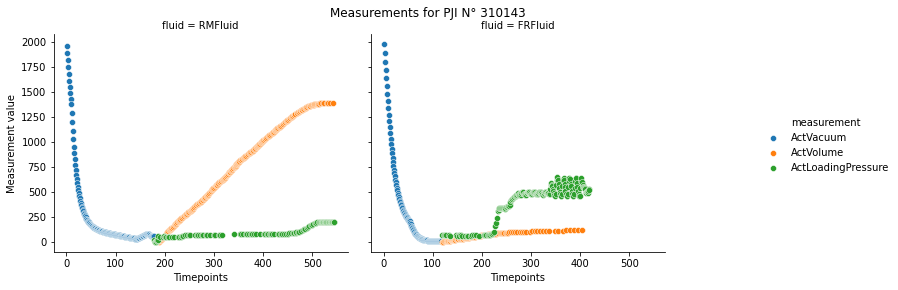

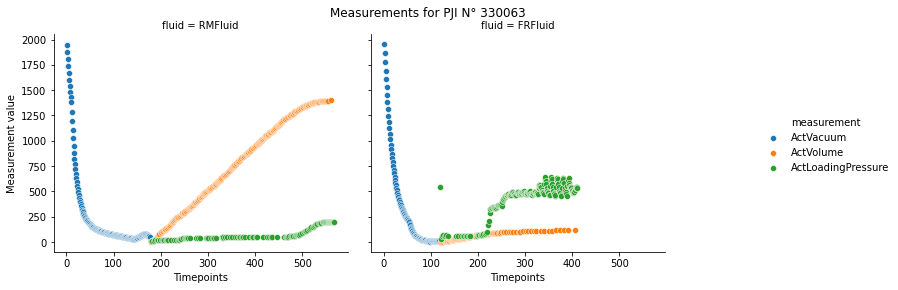

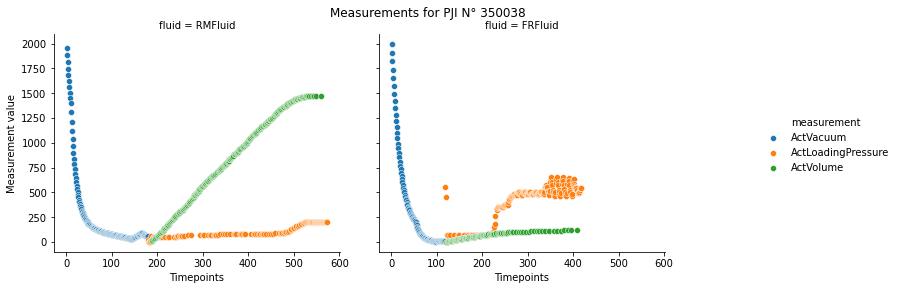

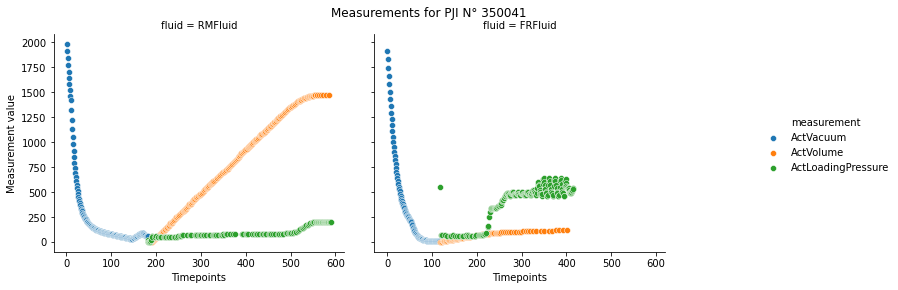

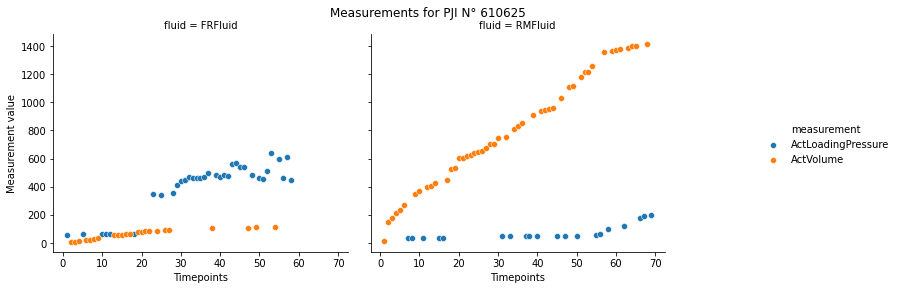

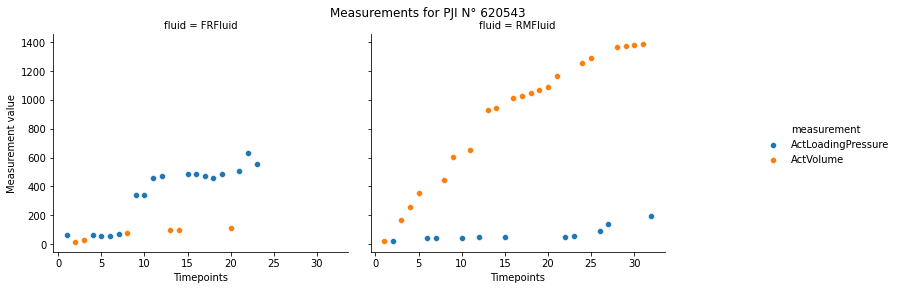

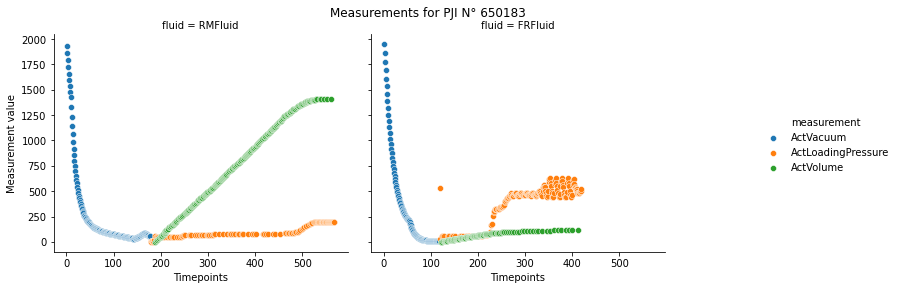

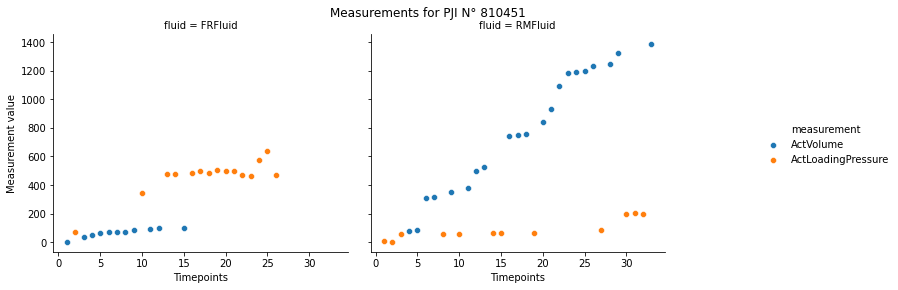

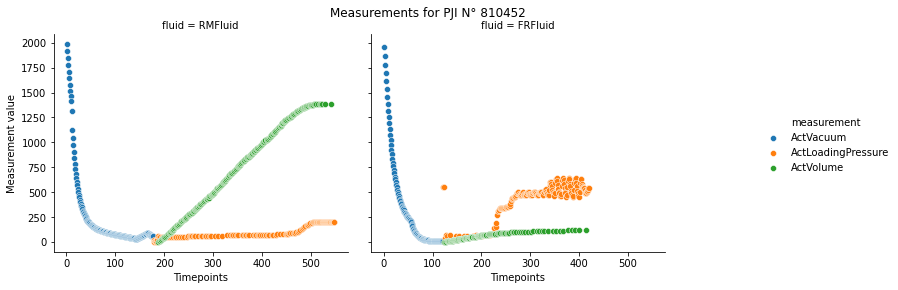

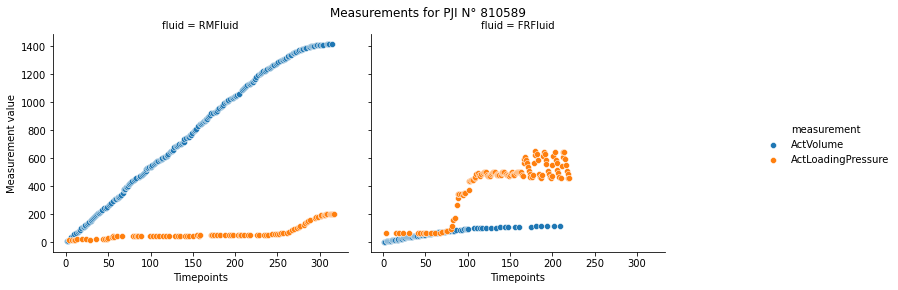

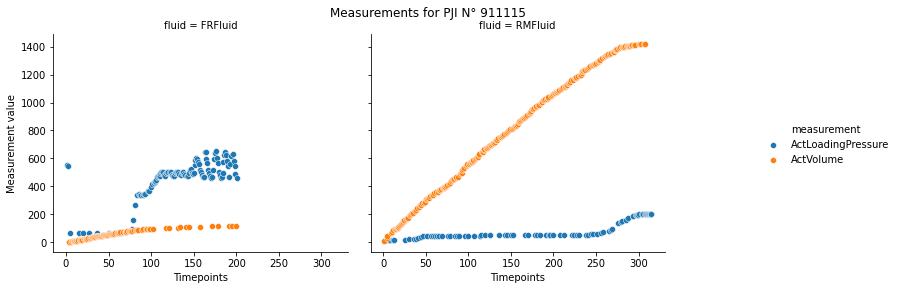

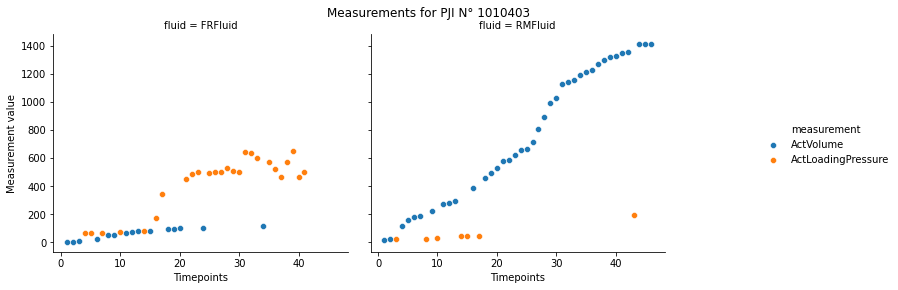

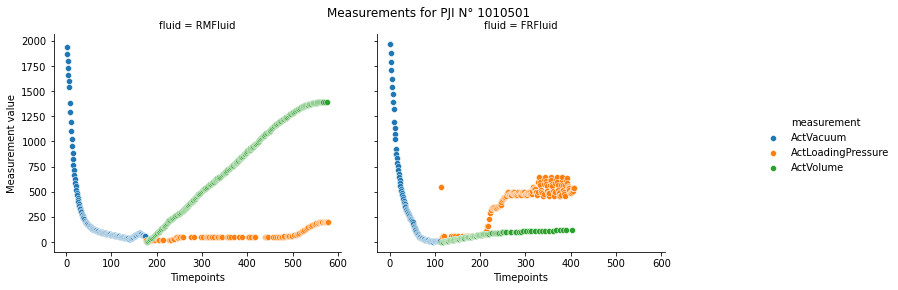

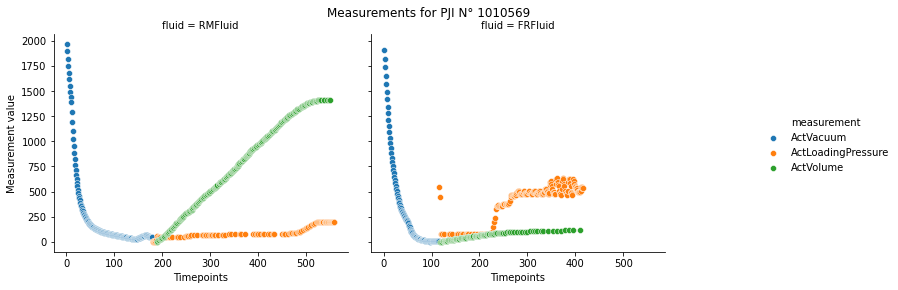

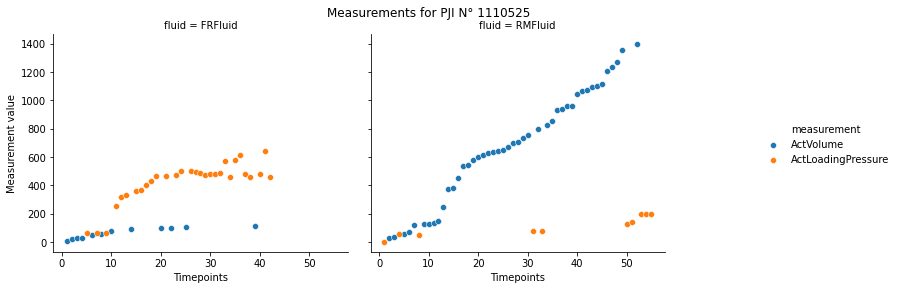

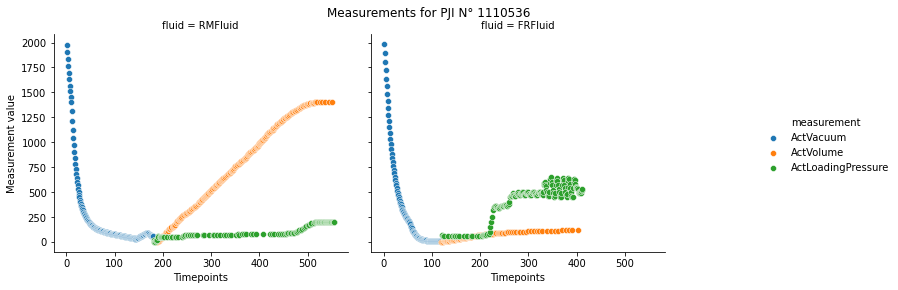

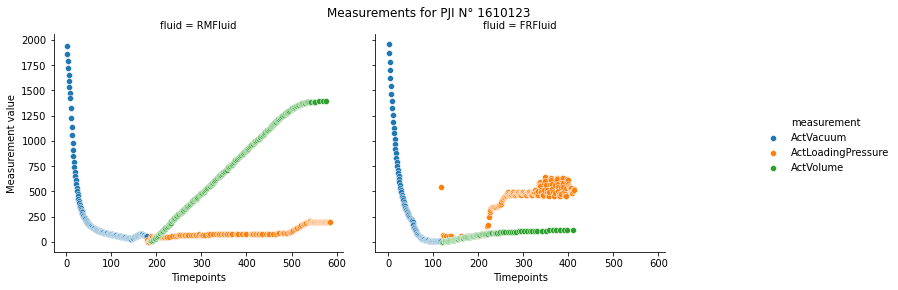

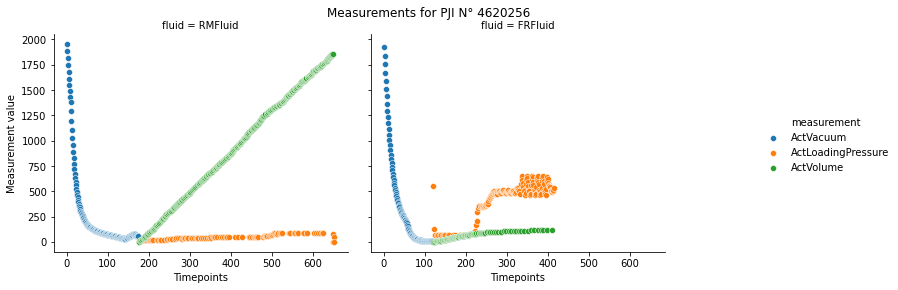

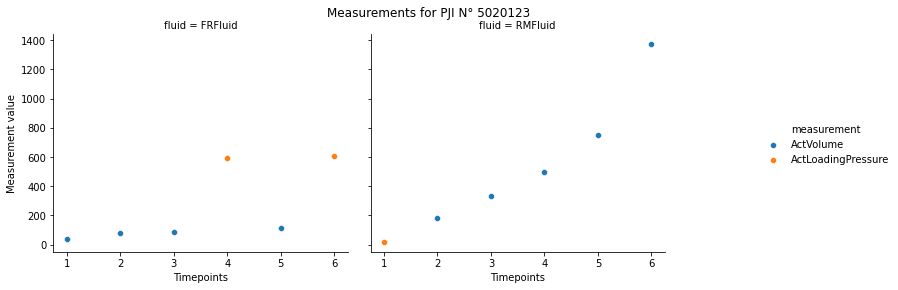

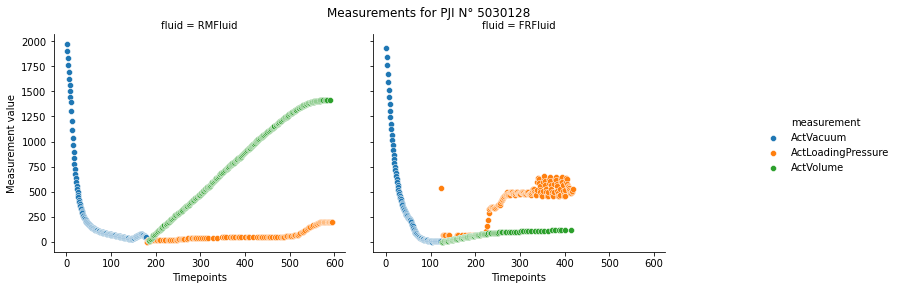

In [24]:
# Checking the type of anomly on test train
# Attention: Not completely accurate due to the option novely=True
lof_train_anomaly = lof.predict(X_train)
for pji in final_df[lof_train_anomaly == -1].index:
    plot_all_fluid(df, pji)

In [29]:
results_lof = pd.DataFrame(lof.predict(X_test),
             columns=['anomaly'])
results_lof.index = test_final_df.index
results_lof['score'] = lof.score_samples(X_test)
results_lof[results_lof.anomaly == -1]

,anomaly,score
pji,,
410339.0,-1,-4.619776
430051.0,-1,-4.786416
430083.0,-1,-1.917538
550279.0,-1,-1.648122


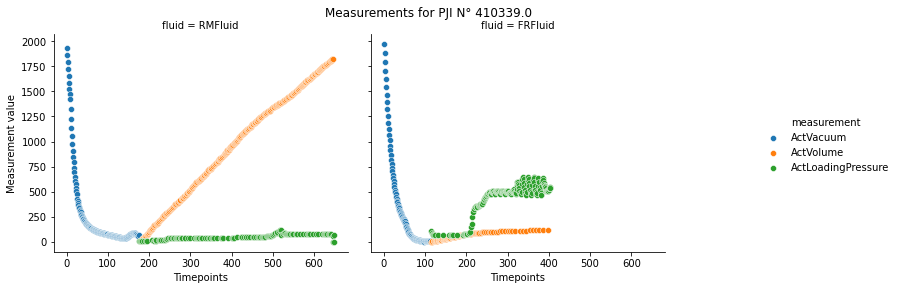

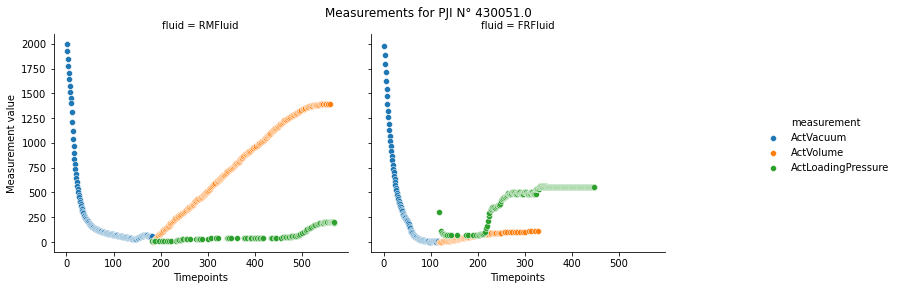

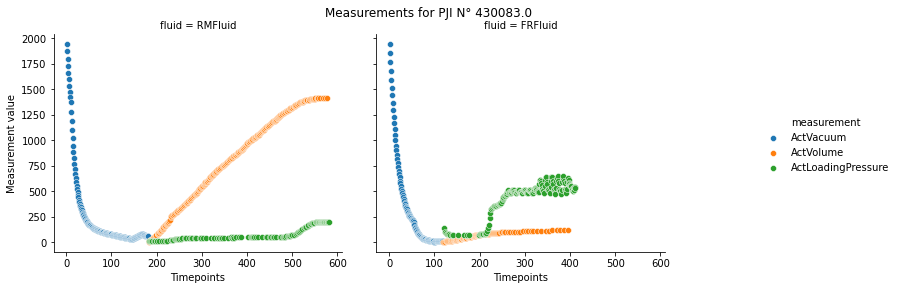

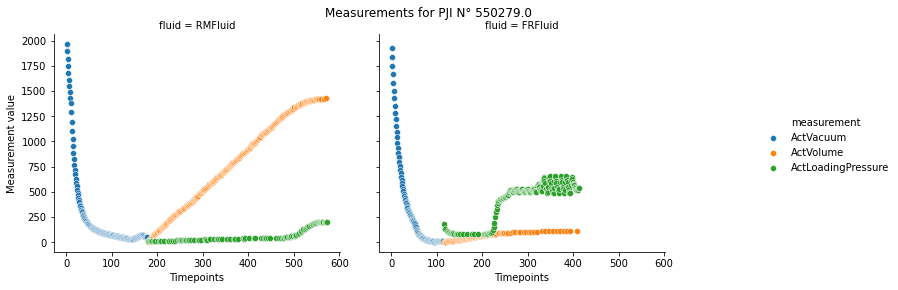

In [30]:
# Plot the detected anomalies in the test set
for pji in results_lof[results_lof.anomaly == -1].index:
    plot_all_fluid(test, pji)

# Combine anomaly results to pji with missing data

In [37]:
# get pji from original test dataset, left join with LOF results
global_results = test[['pji']].drop_duplicates()
global_results = pd.merge(global_results,
                         results_lof.reset_index(),
                         on='pji',
                         how='left')

# Fill NAs with anomaly (bad_pji with missing recordings)
global_results.anomaly.fillna(value=-1, inplace=True)
print(global_results.shape)
global_results[global_results.anomaly == -1]

(61, 3)


,pji,anomaly,score
2,550279.0,-1.0,-1.648122
27,430051.0,-1.0,-4.786416
29,430083.0,-1.0,-1.917538
54,410339.0,-1.0,-4.619776
55,420147.0,-1.0,NaN


In [32]:
global_results.to_csv('../data/inference_results_ATC.csv', index=False)

# Example of possible implementation

In [65]:
anomaly = AnomalyDetection(working_df)

anomaly.filter_preprocess_train_data()

anomaly.fit_on_train()

anomaly.filter_preprocess_test_data(test_reshaped)

results = anomaly.return_predictions()

In [66]:
results[results.anomaly == True]

,pji,anomaly,score
2,550279.0,True,-1.648122
27,430051.0,True,-4.786416
29,430083.0,True,-1.917538
54,410339.0,True,-4.619776
55,420147.0,True,NaN
